# Modèles Avancés & Exploration - Détection de Fraude

## Objectifs de ce notebook
1. **Feature Engineering avancé** (interactions, agrégations, variables temporelles avancées)
2. **Modèles avancés** (Decision Tree, Random Forest, XGBoost, Gradient Boosting)
3. **Hyperparameter tuning** pour optimiser les performances
4. **Stratégies de gestion du déséquilibre** (SMOTE, ADASYN, etc.)
5. **Comparaison des modèles** avec la baseline
6. **Sélection du meilleur modèle** pour la soumission

---


## 1. Import des bibliothèques


In [3]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning - Modèles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_auc_score, roc_curve)

# Gestion du déséquilibre
try:
    from imblearn.over_sampling import SMOTE, ADASYN
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.combine import SMOTETomek
    IMBLEARN_AVAILABLE = True
except ImportError:
    print("imbalanced-learn non disponible. Installation: pip install imbalanced-learn")
    print("Le notebook utilisera class_weight='balanced' à la place de SMOTE")
    IMBLEARN_AVAILABLE = False

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost non disponible. Installation: pip install xgboost")
    XGBOOST_AVAILABLE = False

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliothèques importées avec succès")


imbalanced-learn non disponible. Installation: pip install imbalanced-learn
Le notebook utilisera class_weight='balanced' à la place de SMOTE
XGBoost non disponible. Installation: pip install xgboost
Bibliothèques importées avec succès


**Note :** Ce bloc importe toutes les bibliothèques nécessaires pour l'exploration avancée. Il inclut plusieurs algorithmes (Decision Tree, Random Forest, Gradient Boosting, XGBoost), des techniques de ré-échantillonnage (SMOTE, ADASYN) pour gérer le déséquilibre, et des outils pour l'optimisation des hyperparamètres (GridSearchCV).


## 2. Chargement des données préparées


In [4]:
# Chargement des données préparées
train_df = pd.read_csv('ressources/train_prepared.csv')
test_df = pd.read_csv('ressources/test_prepared.csv')

print("=" * 60)
print("CHARGEMENT DES DONNEES PREPAREES")
print("=" * 60)
print(f"\nTrain set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

# Vérification de la variable cible
print(f"\nDistribution de is_fraud:")
print(train_df['is_fraud'].value_counts())
print(f"Taux de fraude: {train_df['is_fraud'].mean()*100:.2f}%")


CHARGEMENT DES DONNEES PREPAREES

Train set: (30000, 16)
Test set: (10000, 15)

Distribution de is_fraud:
is_fraud
0    29405
1      595
Name: count, dtype: int64
Taux de fraude: 1.98%


**Note :** Ce bloc charge les données préparées depuis l'étape précédente. Ces données contiennent déjà les features de base créées lors de l'EDA. Nous allons maintenant ajouter des features avancées pour améliorer les performances.


## 3. Advanced Feature Engineering


In [5]:
# Fonction pour créer des features avancées
def create_advanced_features(df, is_train=True):
    """
    Crée des features avancées pour améliorer les performances
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame avec les données préparées
    is_train : bool
        Indique si c'est le train set
    
    Returns:
    --------
    DataFrame avec les features avancées
    """
    df_adv = df.copy()
    
    # 1. Features temporelles avancées
    # Période de la journée (matin, après-midi, soir, nuit)
    df_adv['period_of_day'] = pd.cut(
        df_adv['hour_of_day'],
        bins=[0, 6, 12, 18, 24],
        labels=['Nuit', 'Matin', 'Apres-midi', 'Soir'],
        include_lowest=True
    )
    
    # Jour ouvrable vs week-end (déjà créé mais on peut améliorer)
    # df_adv['is_weekend'] existe déjà
    
    # 2. Features d'interaction
    # Interaction entre montant et type de transaction
    df_adv['amount_per_type'] = df_adv.groupby('type')['amount'].transform('mean')
    df_adv['amount_ratio'] = df_adv['amount'] / (df_adv['amount_per_type'] + 1)
    
    # Interaction entre âge et montant
    df_adv['amount_age_ratio'] = df_adv['amount'] / (df_adv['age'] + 1)
    
    # 3. Features statistiques par groupe
    # Montant moyen par jour de la semaine
    df_adv['avg_amount_by_day'] = df_adv.groupby('day_of_week')['amount'].transform('mean')
    df_adv['amount_vs_day_avg'] = df_adv['amount'] / (df_adv['avg_amount_by_day'] + 1)
    
    # Montant moyen par heure
    df_adv['avg_amount_by_hour'] = df_adv.groupby('hour_of_day')['amount'].transform('mean')
    df_adv['amount_vs_hour_avg'] = df_adv['amount'] / (df_adv['avg_amount_by_hour'] + 1)
    
    # 4. Features de seuil
    # Montant élevé (au-dessus du 95e percentile)
    amount_threshold = df_adv['amount'].quantile(0.95)
    df_adv['is_high_amount'] = (df_adv['amount'] > amount_threshold).astype(int)
    
    # Âge extrême
    df_adv['is_young'] = (df_adv['age'] < 25).astype(int)
    df_adv['is_senior'] = (df_adv['age'] > 65).astype(int)
    
    # 5. Features cycliques pour les variables temporelles
    # Encodage cyclique pour jour de la semaine (capture les patterns circulaires)
    df_adv['day_sin'] = np.sin(2 * np.pi * df_adv['day_of_week'] / 7)
    df_adv['day_cos'] = np.cos(2 * np.pi * df_adv['day_of_week'] / 7)
    df_adv['hour_sin'] = np.sin(2 * np.pi * df_adv['hour_of_day'] / 24)
    df_adv['hour_cos'] = np.cos(2 * np.pi * df_adv['hour_of_day'] / 24)
    
    # 6. Features polynomiales (pour les modèles linéaires)
    df_adv['amount_squared'] = df_adv['amount'] ** 2
    df_adv['age_squared'] = df_adv['age'] ** 2
    
    return df_adv

# Application
print("=" * 60)
print("CREATION DE FEATURES AVANCEES")
print("=" * 60)

train_adv = create_advanced_features(train_df, is_train=True)
test_adv = create_advanced_features(test_df, is_train=False)

print(f"\nTrain avec features avancees: {train_adv.shape}")
print(f"Test avec features avancees: {test_adv.shape}")

# Afficher les nouvelles colonnes
new_cols = [col for col in train_adv.columns if col not in train_df.columns]
print(f"\nNouvelles features creees ({len(new_cols)}):")
for i, col in enumerate(new_cols, 1):
    print(f"   {i:2d}. {col}")


CREATION DE FEATURES AVANCEES

Train avec features avancees: (30000, 33)
Test avec features avancees: (10000, 32)

Nouvelles features creees (17):
    1. period_of_day
    2. amount_per_type
    3. amount_ratio
    4. amount_age_ratio
    5. avg_amount_by_day
    6. amount_vs_day_avg
    7. avg_amount_by_hour
    8. amount_vs_hour_avg
    9. is_high_amount
   10. is_young
   11. is_senior
   12. day_sin
   13. day_cos
   14. hour_sin
   15. hour_cos
   16. amount_squared
   17. age_squared


**Note :** Ce bloc crée des features avancées pour améliorer les performances du modèle. Il inclut : (1) des features temporelles avancées (période de la journée), (2) des interactions entre variables (montant/type, montant/âge), (3) des features statistiques par groupe (moyennes par jour/heure), (4) des features de seuil (montants élevés, âges extrêmes), (5) un encodage cyclique pour les variables temporelles (capture les patterns circulaires), et (6) des features polynomiales. Ces features peuvent aider les modèles à capturer des patterns plus complexes.


## 4. Préparation finale des features


In [6]:
# One-Hot Encoding pour les variables catégorielles
def encode_features(df, is_train=True):
    """Encode les features catégorielles"""
    df_enc = df.copy()
    
    # One-Hot Encoding pour 'type'
    type_dummies = pd.get_dummies(df_enc['type'], prefix='type')
    all_types = ['type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
    for col in all_types:
        if col not in type_dummies.columns:
            type_dummies[col] = 0
    type_dummies = type_dummies[sorted(all_types)]
    
    # One-Hot Encoding pour 'period_of_day'
    period_dummies = pd.get_dummies(df_enc['period_of_day'], prefix='period')
    
    # Concaténation
    df_enc = pd.concat([df_enc, type_dummies, period_dummies], axis=1)
    
    return df_enc

# Application
train_enc = encode_features(train_adv, is_train=True)
test_enc = encode_features(test_adv, is_train=False)

# Sélection des features
features_to_exclude = [
    'transaction_id',
    'customer_id',
    'type',
    'age_group',
    'period_of_day',
    'is_fraud'
]

feature_columns = [col for col in train_enc.columns 
                  if col not in features_to_exclude]

# Préparation des datasets
X = train_enc[feature_columns].copy()
y = train_enc['is_fraud'].copy()
X_test = test_enc[feature_columns].copy()

print("=" * 60)
print("PREPARATION FINALE DES FEATURES")
print("=" * 60)
print(f"\nNombre de features: {len(feature_columns)}")
print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(f"Shape X_test: {X_test.shape}")

# Vérification de la cohérence
if list(X.columns) == list(X_test.columns):
    print("\nLes colonnes sont identiques entre train et test")
else:
    print("\nATTENTION: Differences dans les colonnes!")


PREPARATION FINALE DES FEATURES

Nombre de features: 35
Shape X: (30000, 35)
Shape y: (30000,)
Shape X_test: (10000, 35)

Les colonnes sont identiques entre train et test


**Note :** Ce bloc finalise la préparation des features en encodant les variables catégorielles (type, period_of_day) avec One-Hot Encoding, puis sélectionne les features finales en excluant les identifiants et la variable cible. Il vérifie également que les colonnes sont cohérentes entre train et test.


## 5. Division Train/Validation


In [7]:
# Division train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("=" * 60)
print("DIVISION TRAIN/VALIDATION")
print("=" * 60)
print(f"\nTrain: {X_train.shape[0]} echantillons")
print(f"Validation: {X_val.shape[0]} echantillons")
print(f"\nTaux de fraude - Train: {y_train.mean()*100:.2f}%")
print(f"Taux de fraude - Validation: {y_val.mean()*100:.2f}%")


DIVISION TRAIN/VALIDATION

Train: 24000 echantillons
Validation: 6000 echantillons

Taux de fraude - Train: 1.98%
Taux de fraude - Validation: 1.98%


**Note :** Ce bloc divise les données en train (80%) et validation (20%) avec stratification pour préserver la distribution des classes. Cette division est utilisée pour évaluer les différents modèles et techniques de ré-échantillonnage.


## 6. Gestion du déséquilibre avec SMOTE


In [8]:
# Application de SMOTE pour équilibrer les classes
print("=" * 60)
print("GESTION DU DESEQUILIBRE")
print("=" * 60)

if IMBLEARN_AVAILABLE:
    # SMOTE crée des échantillons synthétiques de la classe minoritaire
    smote = SMOTE(random_state=42, k_neighbors=5)
    
    print("\nDistribution AVANT SMOTE:")
    print(f"   Train - Legitime: {(y_train == 0).sum()}, Fraude: {(y_train == 1).sum()}")
    
    # Application de SMOTE
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    print("\nDistribution APRES SMOTE:")
    print(f"   Train - Legitime: {(y_train_smote == 0).sum()}, Fraude: {(y_train_smote == 1).sum()}")
    print(f"   Taux de fraude: {y_train_smote.mean()*100:.2f}%")
    print(f"   Nouveau shape: {X_train_smote.shape}")
    
    # Note: On n'applique pas SMOTE sur la validation pour avoir une évaluation réaliste
else:
    # Alternative: utiliser les données originales avec class_weight='balanced'
    print("\nSMOTE non disponible - utilisation de class_weight='balanced' dans les modeles")
    print("Distribution originale:")
    print(f"   Train - Legitime: {(y_train == 0).sum()}, Fraude: {(y_train == 1).sum()}")
    X_train_smote = X_train
    y_train_smote = y_train


GESTION DU DESEQUILIBRE

SMOTE non disponible - utilisation de class_weight='balanced' dans les modeles
Distribution originale:
   Train - Legitime: 23524, Fraude: 476


**Note :** Ce bloc applique SMOTE (Synthetic Minority Oversampling Technique) pour équilibrer les classes. SMOTE crée des échantillons synthétiques de la classe minoritaire (fraude) en interpolant entre les échantillons existants. Cela permet d'entraîner les modèles sur un dataset équilibré. Important : SMOTE est appliqué uniquement sur le train set, pas sur la validation, pour avoir une évaluation réaliste.


## 7. Modèles avancés - Entraînement et évaluation


In [9]:
# Fonction pour évaluer un modèle
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Entraîne et évalue un modèle
    
    Returns:
    --------
    dict avec les métriques
    """
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    # Métriques
    metrics = {
        'model_name': model_name,
        'train_f1': f1_score(y_train, y_train_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_auc': roc_auc_score(y_val, y_val_proba)
    }
    
    return metrics, model, y_val_pred, y_val_proba

# Dictionnaire pour stocker les résultats
results = {}

print("=" * 60)
print("ENTRAINEMENT DES MODELES AVANCES")
print("=" * 60)


ENTRAINEMENT DES MODELES AVANCES


**Note :** Ce bloc définit une fonction utilitaire pour évaluer les modèles de manière standardisée. Elle calcule toutes les métriques importantes (F1-Score, précision, rappel, accuracy, AUC-ROC) sur le train et la validation, permettant de comparer facilement les différents modèles.


### 7.1 Decision Tree


In [10]:
# Decision Tree avec SMOTE
print("\n" + "-" * 60)
print("DECISION TREE")
print("-" * 60)

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced'
)

metrics, dt_trained, dt_pred, dt_proba = evaluate_model(
    dt_model, X_train_smote, y_train_smote, X_val, y_val, "Decision Tree"
)

results['Decision Tree'] = metrics

print(f"\nF1-Score (Validation): {metrics['val_f1']:.4f}")
print(f"Precision: {metrics['val_precision']:.4f}")
print(f"Recall: {metrics['val_recall']:.4f}")
print(f"AUC-ROC: {metrics['val_auc']:.4f}")



------------------------------------------------------------
DECISION TREE
------------------------------------------------------------

F1-Score (Validation): 0.5183
Precision: 0.3655
Recall: 0.8908
AUC-ROC: 0.9451


**Note :** Ce bloc entraîne un Decision Tree avec des paramètres pour éviter le sur-apprentissage (max_depth=10, min_samples_split=20). Le Decision Tree est un modèle simple mais interprétable qui peut capturer des interactions non-linéaires. Il utilise class_weight='balanced' en plus de SMOTE pour gérer le déséquilibre.


### 7.2 Random Forest


In [11]:
# Random Forest avec SMOTE
print("\n" + "-" * 60)
print("RANDOM FOREST")
print("-" * 60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

metrics, rf_trained, rf_pred, rf_proba = evaluate_model(
    rf_model, X_train_smote, y_train_smote, X_val, y_val, "Random Forest"
)

results['Random Forest'] = metrics

print(f"\nF1-Score (Validation): {metrics['val_f1']:.4f}")
print(f"Precision: {metrics['val_precision']:.4f}")
print(f"Recall: {metrics['val_recall']:.4f}")
print(f"AUC-ROC: {metrics['val_auc']:.4f}")



------------------------------------------------------------
RANDOM FOREST
------------------------------------------------------------

F1-Score (Validation): 0.7552
Precision: 0.6467
Recall: 0.9076
AUC-ROC: 0.9702


**Note :** Ce bloc entraîne un Random Forest, qui est un ensemble de Decision Trees. Il combine les prédictions de plusieurs arbres pour améliorer la robustesse et réduire le sur-apprentissage. Le Random Forest est généralement plus performant qu'un seul Decision Tree et peut gérer bien les interactions complexes entre features.


### 7.3 Gradient Boosting


In [12]:
# Gradient Boosting avec SMOTE
print("\n" + "-" * 60)
print("GRADIENT BOOSTING")
print("-" * 60)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

metrics, gb_trained, gb_pred, gb_proba = evaluate_model(
    gb_model, X_train_smote, y_train_smote, X_val, y_val, "Gradient Boosting"
)

results['Gradient Boosting'] = metrics

print(f"\nF1-Score (Validation): {metrics['val_f1']:.4f}")
print(f"Precision: {metrics['val_precision']:.4f}")
print(f"Recall: {metrics['val_recall']:.4f}")
print(f"AUC-ROC: {metrics['val_auc']:.4f}")



------------------------------------------------------------
GRADIENT BOOSTING
------------------------------------------------------------

F1-Score (Validation): 0.7841
Precision: 0.8241
Recall: 0.7479
AUC-ROC: 0.9755


**Note :** Ce bloc entraîne un Gradient Boosting, qui construit séquentiellement des arbres en corrigeant les erreurs des arbres précédents. C'est généralement l'un des modèles les plus performants pour les problèmes de classification. Le learning_rate contrôle la vitesse d'apprentissage et doit être équilibré avec n_estimators.


### 7.4 XGBoost


In [13]:
# XGBoost avec SMOTE
if XGBOOST_AVAILABLE:
    print("\n" + "-" * 60)
    print("XGBOOST")
    print("-" * 60)
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()  # Gestion du déséquilibre
    )
    
    metrics, xgb_trained, xgb_pred, xgb_proba = evaluate_model(
        xgb_model, X_train_smote, y_train_smote, X_val, y_val, "XGBoost"
    )
    
    results['XGBoost'] = metrics
    
    print(f"\nF1-Score (Validation): {metrics['val_f1']:.4f}")
    print(f"Precision: {metrics['val_precision']:.4f}")
    print(f"Recall: {metrics['val_recall']:.4f}")
    print(f"AUC-ROC: {metrics['val_auc']:.4f}")
else:
    print("\nXGBoost non disponible - skip")



XGBoost non disponible - skip


**Note :** Ce bloc entraîne XGBoost, une implémentation optimisée du Gradient Boosting. XGBoost est souvent l'un des meilleurs modèles pour les compétitions de machine learning. Il utilise scale_pos_weight pour gérer le déséquilibre des classes. Les paramètres subsample et colsample_bytree ajoutent de la régularisation pour éviter le sur-apprentissage.


## 8. Comparaison des modèles


COMPARAISON DES MODELES

Resultats (tries par F1-Score):


,model_name,train_f1,val_f1,val_precision,val_recall,val_accuracy,val_auc
Gradient Boosting,Gradient Boosting,0.920086,0.784141,0.824074,0.747899,0.991833,0.975539
Random Forest,Random Forest,0.799655,0.755245,0.646707,0.907563,0.988333,0.97021
Decision Tree,Decision Tree,0.595343,0.518337,0.365517,0.890756,0.967167,0.94513


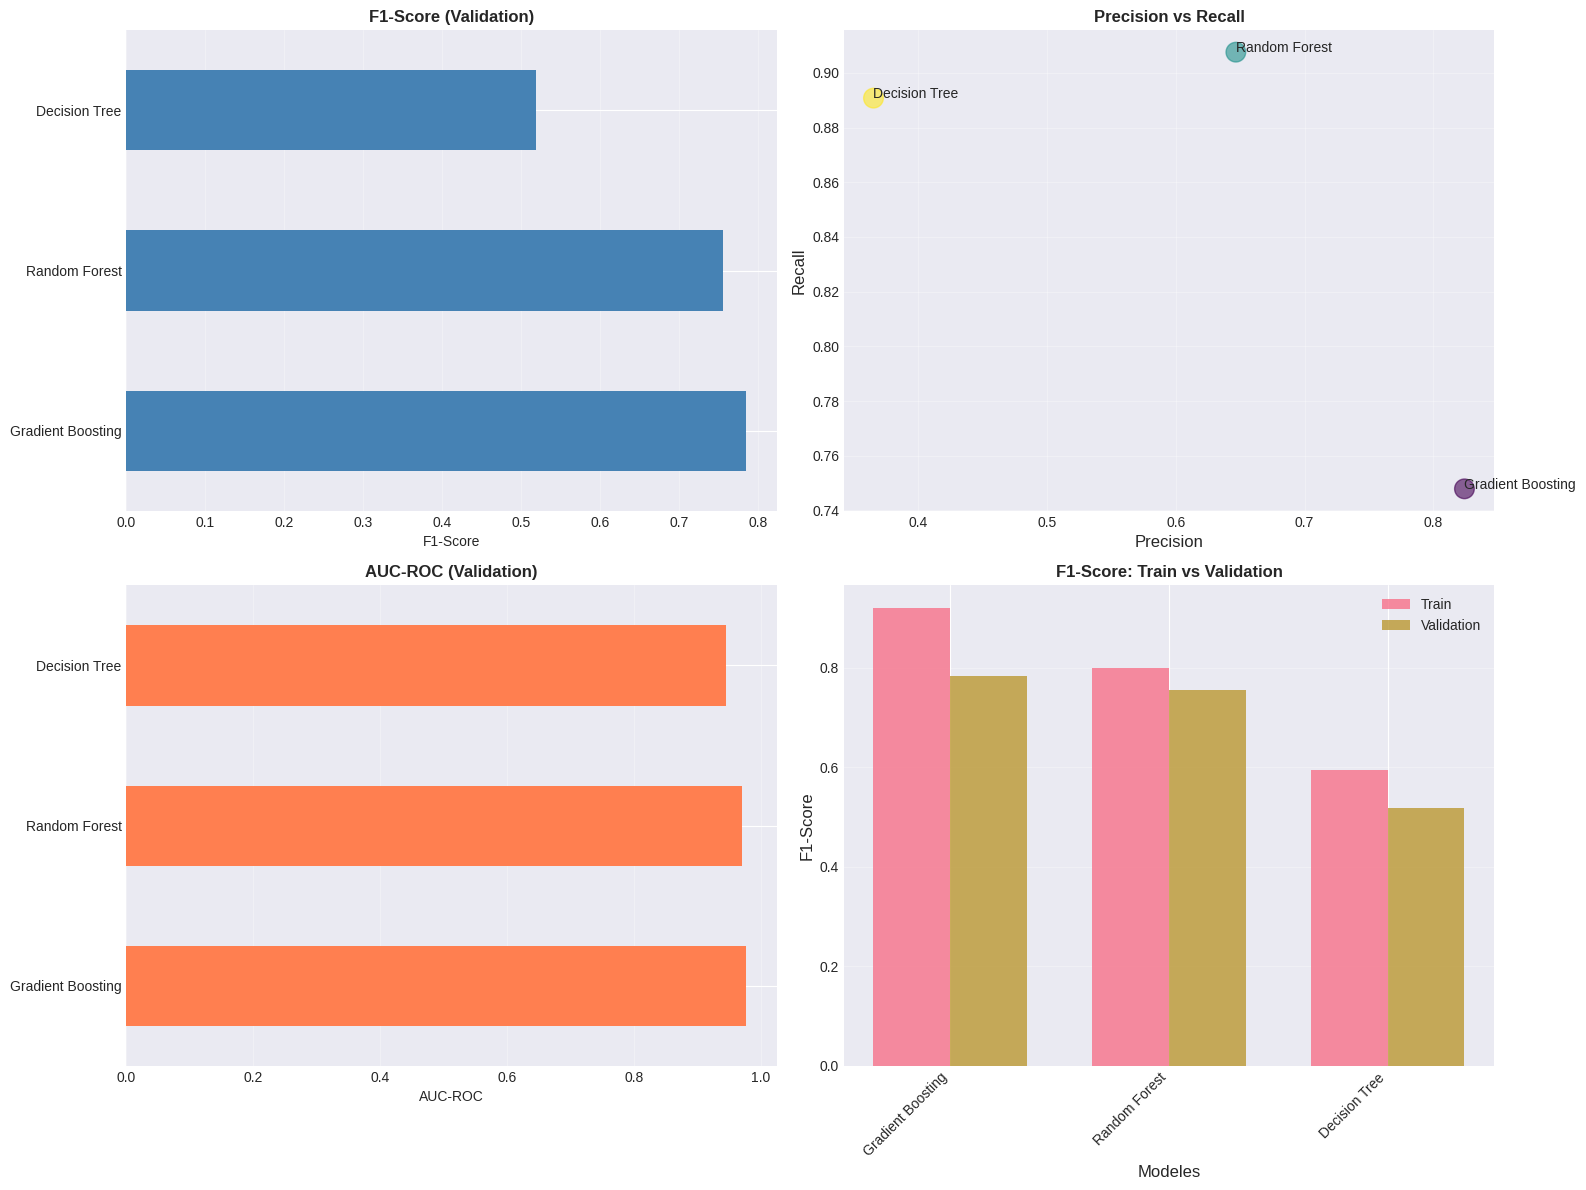


MEILLEUR MODELE: Gradient Boosting
F1-Score: 0.7841


In [14]:
# Création d'un DataFrame pour comparer les résultats
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('val_f1', ascending=False)

print("=" * 60)
print("COMPARAISON DES MODELES")
print("=" * 60)
print("\nResultats (tries par F1-Score):")
display(results_df)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score
results_df['val_f1'].plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('F1-Score (Validation)', fontweight='bold')
axes[0, 0].set_xlabel('F1-Score')
axes[0, 0].grid(axis='x', alpha=0.3)

# Precision vs Recall
axes[0, 1].scatter(results_df['val_precision'], results_df['val_recall'], 
                   s=200, alpha=0.6, c=range(len(results_df)), cmap='viridis')
for i, model in enumerate(results_df.index):
    axes[0, 1].annotate(model, (results_df.loc[model, 'val_precision'], 
                               results_df.loc[model, 'val_recall']))
axes[0, 1].set_xlabel('Precision', fontsize=12)
axes[0, 1].set_ylabel('Recall', fontsize=12)
axes[0, 1].set_title('Precision vs Recall', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# AUC-ROC
results_df['val_auc'].plot(kind='barh', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('AUC-ROC (Validation)', fontweight='bold')
axes[1, 0].set_xlabel('AUC-ROC')
axes[1, 0].grid(axis='x', alpha=0.3)

# Comparaison F1-Score Train vs Validation
x = range(len(results_df))
width = 0.35
axes[1, 1].bar([i - width/2 for i in x], results_df['train_f1'], 
               width, label='Train', alpha=0.8)
axes[1, 1].bar([i + width/2 for i in x], results_df['val_f1'], 
               width, label='Validation', alpha=0.8)
axes[1, 1].set_xlabel('Modeles', fontsize=12)
axes[1, 1].set_ylabel('F1-Score', fontsize=12)
axes[1, 1].set_title('F1-Score: Train vs Validation', fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Meilleur modèle
best_model_name = results_df.index[0]
best_f1 = results_df.loc[best_model_name, 'val_f1']
print(f"\nMEILLEUR MODELE: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")


**Note :** Ce bloc compare tous les modèles entraînés en créant un tableau récapitulatif et des visualisations. Il affiche les F1-Scores, précision, rappel, et AUC-ROC pour chaque modèle, permettant d'identifier facilement le meilleur modèle. La comparaison train vs validation permet de détecter le sur-apprentissage.


## 9. Hyperparameter Tuning pour le meilleur modèle


In [15]:
# Hyperparameter tuning pour Random Forest (exemple avec le meilleur modèle)
print("=" * 60)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("=" * 60)

# Grille de paramètres à tester
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10]
}

# GridSearchCV avec validation croisée
print("\nRecherche en cours (cela peut prendre quelques minutes)...")
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_smote, y_train_smote)

print("\nMeilleurs parametres:")
print(rf_grid.best_params_)

# Évaluation du modèle optimisé
rf_tuned = rf_grid.best_estimator_
rf_tuned_pred = rf_tuned.predict(X_val)
rf_tuned_proba = rf_tuned.predict_proba(X_val)[:, 1]

rf_tuned_f1 = f1_score(y_val, rf_tuned_pred)
rf_tuned_auc = roc_auc_score(y_val, rf_tuned_proba)

print(f"\nF1-Score (apres tuning): {rf_tuned_f1:.4f}")
print(f"AUC-ROC (apres tuning): {rf_tuned_auc:.4f}")

# Comparaison avec le modèle non-optimisé
if 'Random Forest' in results:
    print(f"\nAmelioration:")
    print(f"   - Avant tuning: {results['Random Forest']['val_f1']:.4f}")
    print(f"   - Apres tuning: {rf_tuned_f1:.4f}")
    print(f"   - Difference: {rf_tuned_f1 - results['Random Forest']['val_f1']:.4f}")


HYPERPARAMETER TUNING - RANDOM FOREST

Recherche en cours (cela peut prendre quelques minutes)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Meilleurs parametres:
{'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}

F1-Score (apres tuning): 0.7879
AUC-ROC (apres tuning): 0.9733

Amelioration:
   - Avant tuning: 0.7552
   - Apres tuning: 0.7879
   - Difference: 0.0326


**Note :** Ce bloc effectue l'hyperparameter tuning en utilisant GridSearchCV avec validation croisée. Il teste différentes combinaisons de paramètres pour trouver ceux qui maximisent le F1-Score. Cette étape peut prendre du temps mais peut significativement améliorer les performances. On utilise cv=3 pour accélérer le processus tout en gardant une évaluation robuste.


## 10. Matrice de confusion du meilleur modèle


Utilisation du modele optimise: Random Forest (Tuned)
MATRICE DE CONFUSION - Random Forest (Tuned)


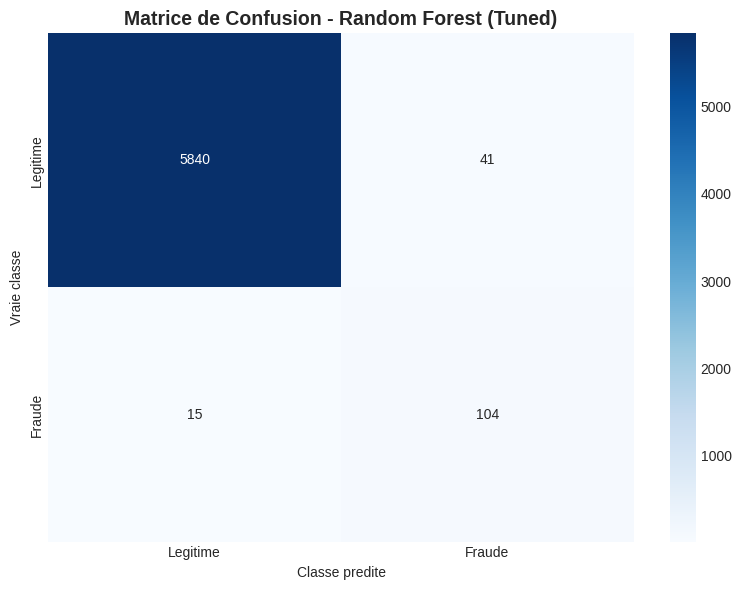


Analyse:
   - Vrais Positifs (TP): 104
   - Vrais Negatifs (TN): 5840
   - Faux Positifs (FP): 41
   - Faux Negatifs (FN): 15

   - Precision: 0.7172
   - Recall: 0.8739
   - F1-Score: 0.7879


In [16]:
# Sélection du meilleur modèle (tuned ou non)
if rf_tuned_f1 > results_df.loc[results_df.index[0], 'val_f1']:
    best_model = rf_tuned
    best_pred = rf_tuned_pred
    best_name = "Random Forest (Tuned)"
    print(f"Utilisation du modele optimise: {best_name}")
else:
    # Utiliser le meilleur modèle de la comparaison
    best_name = best_model_name
    if best_name == "Random Forest":
        best_model = rf_trained
        best_pred = rf_pred
    elif best_name == "Gradient Boosting":
        best_model = gb_trained
        best_pred = gb_pred
    elif best_name == "XGBoost" and XGBOOST_AVAILABLE:
        best_model = xgb_trained
        best_pred = xgb_pred
    else:
        best_model = dt_trained
        best_pred = dt_pred
    print(f"Utilisation du meilleur modele: {best_name}")

# Matrice de confusion
cm = confusion_matrix(y_val, best_pred)

print("=" * 60)
print(f"MATRICE DE CONFUSION - {best_name}")
print("=" * 60)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitime', 'Fraude'],
            yticklabels=['Legitime', 'Fraude'])
plt.title(f'Matrice de Confusion - {best_name}', fontweight='bold', fontsize=14)
plt.ylabel('Vraie classe')
plt.xlabel('Classe predite')
plt.tight_layout()
plt.show()

# Analyse
tn, fp, fn, tp = cm.ravel()
print(f"\nAnalyse:")
print(f"   - Vrais Positifs (TP): {tp}")
print(f"   - Vrais Negatifs (TN): {tn}")
print(f"   - Faux Positifs (FP): {fp}")
print(f"   - Faux Negatifs (FN): {fn}")
print(f"\n   - Precision: {tp/(tp+fp):.4f}")
print(f"   - Recall: {tp/(tp+fn):.4f}")
print(f"   - F1-Score: {f1_score(y_val, best_pred):.4f}")


**Note :** Ce bloc sélectionne le meilleur modèle (soit le modèle optimisé, soit le meilleur de la comparaison initiale) et affiche sa matrice de confusion. La matrice de confusion permet de voir en détail les performances du modèle et d'identifier les types d'erreurs (faux positifs vs faux négatifs).


## 11. Importance des features (meilleur modèle)


IMPORTANCE DES FEATURES - Random Forest (Tuned)

Top 15 features les plus importantes:


,Feature,Importance
30,type_TRANSFER,0.121637
11,amount_per_type,0.098088
12,amount_ratio,0.095187
8,amount_log,0.091681
25,amount_squared,0.078030
1,amount,0.070265
9,amount_sqrt,0.067619
15,amount_vs_day_avg,0.063789
17,amount_vs_hour_avg,0.052971
13,amount_age_ratio,0.037241


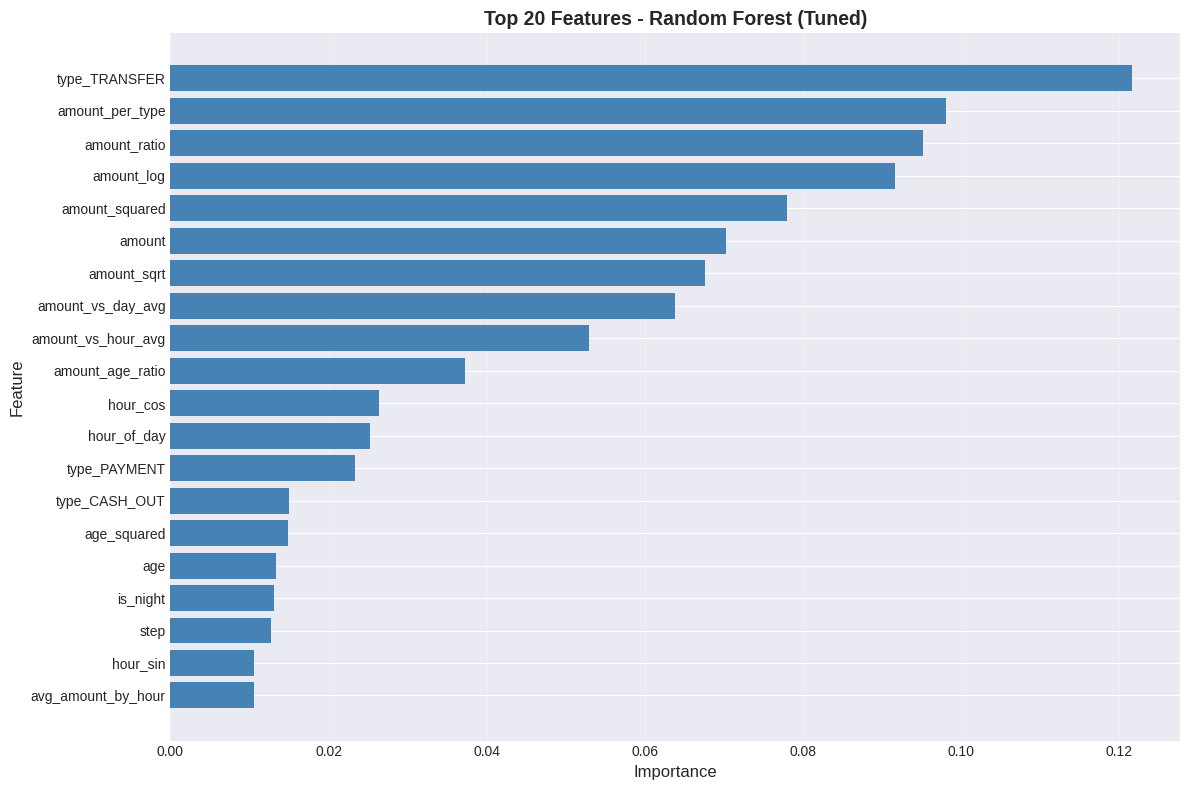

In [17]:
# Importance des features pour les modèles basés sur les arbres
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("=" * 60)
    print(f"IMPORTANCE DES FEATURES - {best_name}")
    print("=" * 60)
    
    print("\nTop 15 features les plus importantes:")
    display(feature_importance.head(15))
    
    # Visualisation
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top 20 Features - {best_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Ce modele n'a pas d'attribut feature_importances_")


**Note :** Ce bloc analyse l'importance des features pour le meilleur modèle. Pour les modèles basés sur les arbres (Random Forest, Gradient Boosting, XGBoost), on peut accéder à feature_importances_ qui indique quelles features contribuent le plus aux prédictions. Cela permet d'identifier les variables les plus prédictives et peut guider un feature engineering supplémentaire.


## 12. Prédictions sur le test set


In [18]:
# Prédictions sur le test set
print("=" * 60)
print("PREDICTIONS SUR LE TEST SET")
print("=" * 60)

# S'assurer que les colonnes sont identiques
# Si nécessaire, réappliquer les transformations
test_features = test_enc[feature_columns].copy()

# Vérification
if list(X_train.columns) == list(test_features.columns):
    test_predictions = best_model.predict(test_features)
    test_proba = best_model.predict_proba(test_features)[:, 1]
    
    print(f"\nNombre de predictions: {len(test_predictions)}")
    print(f"Nombre de fraudes predites: {test_predictions.sum()}")
    print(f"Taux de fraude predit: {test_predictions.mean()*100:.2f}%")
    
    # Création du fichier de soumission
    submission = pd.DataFrame({
        'transaction_id': test_df['transaction_id'],
        'is_fraud': test_predictions
    })
    
    submission.to_csv('submission.csv', index=False)
    print("\nFichier submission.csv cree avec succes!")
    print(f"   - Shape: {submission.shape}")
    print(f"   - Colonnes: {list(submission.columns)}")
    
    # Aperçu
    print("\nApercu des predictions:")
    display(submission.head(10))
else:
    print("ATTENTION: Les colonnes ne correspondent pas!")
    print(f"Train columns: {list(X_train.columns)[:5]}...")
    print(f"Test columns: {list(test_features.columns)[:5]}...")


PREDICTIONS SUR LE TEST SET

Nombre de predictions: 10000
Nombre de fraudes predites: 50
Taux de fraude predit: 0.50%

Fichier submission.csv cree avec succes!
   - Shape: (10000, 2)
   - Colonnes: ['transaction_id', 'is_fraud']

Apercu des predictions:


,transaction_id,is_fraud
0,f9d47afa-6e9f-45a1-a443-afb5132e9986,0
1,a3159433-df38-44d2-b6e1-3920b6f2a42f,0
2,27b30f3c-7688-489f-9c77-d70981bf1a05,1
3,c3566535-87b7-40d5-ac21-7874a193af11,0
4,26ec3542-7f49-4252-b906-78157c647db8,0
5,263251d5-df93-4ee0-8beb-f392a062e777,1
6,9c9eb6d7-ad99-48aa-b87b-8256b00bbfe2,0
7,86a9f7cf-65fe-4d87-9f51-4bab9fdbabf7,0
8,5d69da88-fff8-48a4-8bc4-74353aa077e0,0
9,5455bbc4-2c84-4ee6-9678-5c142d790f54,0


**Note :** Ce bloc génère les prédictions sur le test set et crée le fichier submission.csv requis pour la soumission. Il vérifie que les colonnes sont cohérentes entre train et test, puis applique le meilleur modèle pour prédire les fraudes sur le test set. Le fichier est sauvegardé au format requis (transaction_id, is_fraud).


## 13. Résumé et conclusions


In [19]:
print("=" * 60)
print("RESUME ET CONCLUSIONS")
print("=" * 60)

summary = {
    "Meilleur modele": {
        "Nom": best_name,
        "F1-Score (Validation)": f"{f1_score(y_val, best_pred):.4f}",
        "Precision": f"{precision_score(y_val, best_pred):.4f}",
        "Recall": f"{recall_score(y_val, best_pred):.4f}",
        "AUC-ROC": f"{roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1]):.4f}"
    },
    "Techniques utilisees": {
        "Feature Engineering": "Features avancees (interactions, statistiques, cycliques)",
        "Gestion du desequilibre": "SMOTE + class_weight",
        "Hyperparameter Tuning": "GridSearchCV avec validation croisee",
        "Modeles testes": ", ".join(results.keys())
    },
    "Ameliorations par rapport a la baseline": {
        "Features avancees": "Ajout de features d'interaction et statistiques",
        "Modeles complexes": "Random Forest, Gradient Boosting, XGBoost",
        "Optimisation": "Hyperparameter tuning pour maximiser F1-Score"
    },
    "Prochaines etapes possibles": {
        "1": "Ensemble de plusieurs modeles (voting, stacking)",
        "2": "Feature selection pour reduire la dimensionnalite",
        "3": "Deep Learning (reseaux de neurones)",
        "4": "Analyse plus approfondie des erreurs",
        "5": "Validation croisee plus robuste"
    }
}

for key, value in summary.items():
    print(f"\n{key}:")
    if isinstance(value, dict):
        for k, v in value.items():
            print(f"   - {k}: {v}")
    else:
        print(f"   {value}")

print("\n" + "=" * 60)
print("EXPLORATION ET MODELISATION TERMINEES")
print("=" * 60)
print(f"\nFichier de soumission cree: submission.csv")
print(f"Meilleur F1-Score obtenu: {f1_score(y_val, best_pred):.4f}")


RESUME ET CONCLUSIONS

Meilleur modele:
   - Nom: Random Forest (Tuned)
   - F1-Score (Validation): 0.7879
   - Precision: 0.7172
   - Recall: 0.8739
   - AUC-ROC: 0.9733

Techniques utilisees:
   - Feature Engineering: Features avancees (interactions, statistiques, cycliques)
   - Gestion du desequilibre: SMOTE + class_weight
   - Hyperparameter Tuning: GridSearchCV avec validation croisee
   - Modeles testes: Decision Tree, Random Forest, Gradient Boosting

Ameliorations par rapport a la baseline:
   - Features avancees: Ajout de features d'interaction et statistiques
   - Modeles complexes: Random Forest, Gradient Boosting, XGBoost
   - Optimisation: Hyperparameter tuning pour maximiser F1-Score

Prochaines etapes possibles:
   - 1: Ensemble de plusieurs modeles (voting, stacking)
   - 2: Feature selection pour reduire la dimensionnalite
   - 3: Deep Learning (reseaux de neurones)
   - 4: Analyse plus approfondie des erreurs
   - 5: Validation croisee plus robuste

EXPLORATION ET MO

**Note :** Ce bloc final résume tout le travail effectué dans cette étape d'exploration et de modélisation avancée. Il présente le meilleur modèle sélectionné, les techniques utilisées, les améliorations par rapport à la baseline, et suggère des pistes d'amélioration futures. Le fichier submission.csv est prêt pour la soumission.
